# Sea Level Rise dataset Poisson Loss

In [1]:
import mxnet as mx
import numpy as np
from mxnet import gluon, nd, autograd
mx.random.seed(1)
import pandas as pd

from mxnet.gluon import nn
%matplotlib inline
from matplotlib import pyplot as plt

/Users/gireeg/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetching dataset

            GMSL
Time            
1993-01-15  -1.6
1993-02-15  -3.4
1993-03-15   5.5
1993-04-15   0.1
1993-05-15   5.3


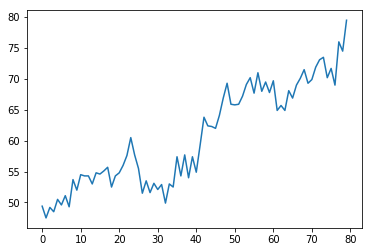

In [2]:
df = pd.read_csv("https://datahub.io/core/sea-level-rise/r/csiro_alt_gmsl_mo_2015.csv").set_index('Time')
df
print(df.head())

ts = df.values[-80:,0]

plt.plot(ts);

In [3]:
forecast_length = 10
train_length = len(ts) - forecast_length

tgt_min = ts.min()
ts = ts - tgt_min

# droping the first observation due to lag
target = nd.array(ts[:train_length]).reshape((train_length,1))[1:]

# prediction target
pred_target = nd.array(ts[train_length:]).reshape((forecast_length,1))

# construct lag and trend
trend = nd.arange(train_length).reshape((train_length,1))
lag_sales = nd.array(ts).reshape((train_length,1))

# droping the last observation due to lag
features = nd.concat(trend[:-1],lag_sales[:-1])

# standardize
features_mean = features.mean(axis=0)
features_std = nd.array(features.asnumpy().std(axis=0)).reshape((1,1))
features = (features - features_mean) / features_std

print(features[:5,])
print(target[:5,])
num_examples = features.shape[0]


[[-1.7071279  -0.4745903 ]
 [-1.6569183  -0.5699886 ]
 [-1.6067086  -0.48463222]
 [-1.556499   -0.51977897]
 [-1.5062894  -0.41935968]]
<NDArray 5x2 @cpu(0)>

[[0. ]
 [1.7]
 [1. ]
 [3. ]
 [2.1]]
<NDArray 5x1 @cpu(0)>


In [4]:
# Use data loader to lad the data from the dataset

In [5]:
batch_size = 3
train_data = gluon.data.DataLoader(
    gluon.data.ArrayDataset(features, target),
    batch_size=batch_size, shuffle=True)

In [6]:
def poisson_loss(#self, 
    F,             #data coming from caller
    pred,          #lambda - the rate of event occuring in a given interval
    target,        #the value of k (result  or the actual number of events happening)
    from_logits  = False,
    sample_weight= None, 
    compute_full = False,
    epsilon = 1e-12
    ):
        F=nd
        if from_logits:
            loss = F.exp(pred) - target * pred
        else:
            loss = pred - target * nd.log(pred+epsilon)
        
        return F.mean(loss)

In [7]:
net = nn.Sequential()
#Add a sequence of layers.
net.add(
    nn.Dense(1,activation='tanh'),
    nn.Dense(1)
)
  
net

Sequential(
  (0): Dense(None -> 1, Activation(tanh))
  (1): Dense(None -> 1, linear)
)

In [8]:
def poissonloss_hidden(X):
    yhat1 = net(X);
    yhat = nd.exp(yhat1)
    return yhat

In [9]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=mx.cpu())

In [10]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02})

In [11]:
epochs = 20
loss_sequence = []
loss_seq = []
niter = 0
epochslist = []
num_batches = num_examples / batch_size
smoothing_constant = 0.5
moving_loss = 0

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):

        with autograd.record():
            output = poissonloss_hidden(data)
            loss =  poisson_loss(None,output, label, from_logits=False, compute_full=False)
        loss.backward()
        trainer.step(batch_size)
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        loss_seq.append(est_loss)
        cumulative_loss += nd.mean(loss).asscalar()
    if e % 10 == 0:    
        print("Epoch %s, loss: %s" % (e, cumulative_loss / num_examples))
    loss_sequence.append(cumulative_loss/num_examples)
    epochslist.append(e)

Epoch 0, loss: -3.8717022179693417
Epoch 10, loss: -6.320113512053006


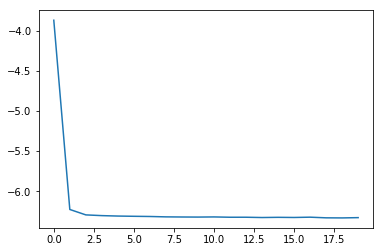

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(epochslist,loss_sequence)

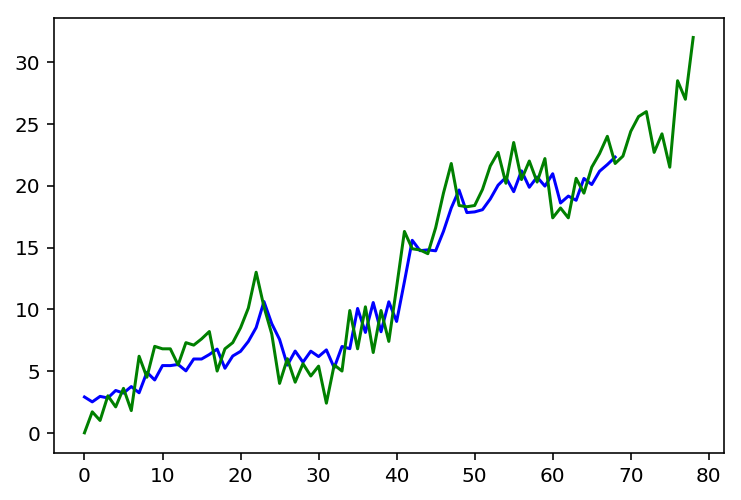

In [28]:
def plot_forecast(observed, fitted):
    plt.plot(fitted.asnumpy(), color="b")
    plt.plot(observed, color="g")
    T = len(fitted)
#     plt.plot(np.arange(T, T+len(forecasted)), forecasted.asnumpy(), color="b")
#     plt.legend(["Fitted", "Observed", "Forecasted"]);
 
    
fit = (poissonloss_hidden(features))
plot_forecast(ts[1:],fit)

In [29]:
# New code for forecasting...
def forecast_poisson(pl, last_obs, features_mean, features_std,
                     forecast_length, train_length):
    forecast = nd.empty((forecast_length,1))
    for t in range(forecast_length):
        if t==0:
            prev_obs = last_obs.reshape((1,1))
        # construct features
        trend = nd.array([train_length + t - 1]).reshape((1,1))
        #fct_feat = trend
        fct_feat = nd.concat(trend,prev_obs,dim=1)
        # normalize features
        fct_feat = (fct_feat - features_mean)/features_std
        # forecast
        fct = pl(fct_feat)
        forecast[t,] = fct[0][0]
        prev_obs = fct
    return forecast
  
fit = poissonloss_hidden(features)    
#fit_trans = inverse_logistic(fit)

fct = forecast_poisson(poissonloss_hidden,target[train_length-2],
                            features_mean, features_std,
                            forecast_length, train_length)
#fct_trans = inverse_logistic(fct)

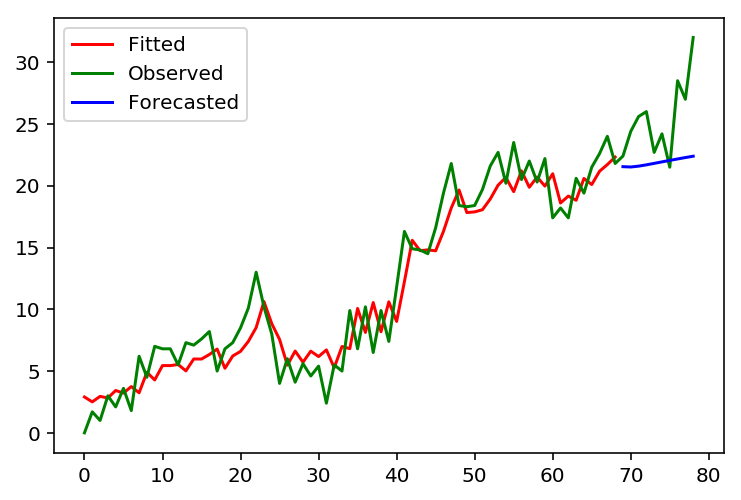

In [30]:
def plot_forecast(observed, fitted, forecasted):
    plt.plot(fitted.asnumpy(), color="r")
    plt.plot(observed, color="g")
    T = len(fitted)
    plt.plot(np.arange(T, T+len(forecasted)), forecasted.asnumpy(), color="b")
    plt.legend(["Fitted", "Observed", "Forecasted"]);
    
plot_forecast(ts[1:],fit,fct)

In [31]:
ts.shape, features[0]

((80,), 
 [-1.7071279 -0.4745903]
 <NDArray 2 @cpu(0)>)

In [270]:
ts_rest = df.values[:-80,0]

In [277]:
trend.shape,lag_sales.shape

((70, 1), (70, 1))

In [ ]:
# plot the convergence of the estimated loss function
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6),dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(niter),loss_seq, '.')

# adding some additional bells and whistles to the plot
plt.grid(True,which="both")
plt.xlabel('iteration',fontsize=14)
plt.ylabel('est loss',fontsize=14)